In [4]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [74]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
data_directory = './data/lunar/training/data/S12_GradeA/'

WINDOW_SIZE = 8000
STEP_SIZE = 1000

cat = pd.read_csv(cat_file)

In [70]:
# Power, bandwidth, spectral entropy, peak frequency, dominant frequency, centroid frequency, mean frequency and spectral amplitude

def get_power(dataframe):
    # The power of a signal is the sum of the squares of the absolute values of the signal's time-domain samples divided by the signal length
    data = dataframe.data

    return np.sum(np.abs(data)**2)

def get_bandwidth(dataframe):
    # The bandwidth of a signal is the range of frequencies that it contains
    data = dataframe.data
    fft = np.fft.fft(data)

    return np.sum(np.abs(fft)**2)

def get_spectral_entropy(dataframe):
    data = dataframe.data

    fft = np.fft.fft(data)
    power = np.abs(fft)**2
    power = power / np.sum(power)  # Normalización
    power = power[power > 0]  # Evitar log(0)

    return -np.sum(power * np.log(power))

def get_peak_frequency(dataframe):
    data = dataframe.data.tolist()
    times = dataframe.time.tolist()

    freqs = np.fft.fftfreq(len(times), times[1] - times[0])
    fft = np.fft.fft(data)

    return np.abs(freqs[np.argmax(np.abs(fft))])

def get_dominant_frequency(dataframe):
    data = dataframe.data.tolist()
    times = dataframe.time.tolist()

    freqs = np.fft.fftfreq(len(times), times[1] - times[0])
    fft = np.fft.fft(data)

    return np.abs(freqs[np.argmax(np.abs(fft))])

def get_centroid_frequency(dataframe):
    data = dataframe.data.tolist()
    times = dataframe.time.tolist()

    freqs = np.fft.fftfreq(len(times), times[1] - times[0])
    fft = np.fft.fft(data)

    return np.sum(np.abs(fft) * np.abs(freqs)) / np.sum(np.abs(fft))

def get_mean_frequency(dataframe):
    data = dataframe.data.tolist()
    times = dataframe.time.tolist()

    freqs = np.fft.fftfreq(len(times), times[1] - times[0])
    fft = np.fft.fft(data)

    return np.sum(np.abs(fft) * np.abs(freqs)) / np.sum(np.abs(fft))

def get_spectral_amplitude(dataframe):
    data = dataframe.data

    fft = np.fft.fft(data)

    return np.max(np.abs(fft))

def get_characteristics(dataframe):
    # power = get_power(dataframe)
    # bandwidth = get_bandwidth(dataframe)
    # spectral_entropy = get_spectral_entropy(dataframe)
    # peak_frequency = get_peak_frequency(dataframe)
    # dominant_frequency = get_dominant_frequency(dataframe)
    # centroid_frequency = get_centroid_frequency(dataframe)
    # mean_frequency = get_mean_frequency(dataframe)
    spectral_amplitude = get_spectral_amplitude(dataframe)

    return dict(
        # power=power,
        # bandwidth=bandwidth,
        # spectral_entropy=spectral_entropy,
        # peak_frequency=peak_frequency,
        # dominant_frequency=dominant_frequency,
        # centroid_frequency=centroid_frequency,
        # mean_frequency=mean_frequency,
        spectral_amplitude=spectral_amplitude
    )

def get_file_data(index: int):
    catalog_row = cat.iloc[index]

    filename = catalog_row.filename

    csv_file = f'{data_directory}{filename}.csv'
    data_cat = pd.read_csv(csv_file)

    csv_times = np.array(data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(data_cat['velocity(m/s)'].tolist())

    return pd.DataFrame(dict(
        time=csv_times,
        data=csv_data
    ))

def get_windowed_data(dataframe, offset=0, window_size=WINDOW_SIZE):
    result = []
    data = dataframe.data
    times = dataframe.time

    for i in range(offset, offset + window_size):
        if i >= len(data):
            break

        row = dict(
            time=times[i],
            data=data[i]
        )
        result.append(row)
    
    return pd.DataFrame(result)

def get_tagged_data(untagged_data):
    list = []
    times = untagged_data['times']
    data = untagged_data['data']
    event_time = untagged_data['event_time']

    for i in range(len(times)):
        row = dict(
            time=times[i],
            data=data[i],
            type = 0 if times[i] < event_time else 1
        )
        list.append(row)
    
    return pd.DataFrame(list)

def get_window_type(window):
    # if there is only 0s, is a non-event window
    if np.all(window.type == 0):
        return 0
    # if there is only 1s, is a non-event window
    if np.all(window.type == 1):
        return 2
    # if there is at least one 1, is an event window
    if np.any(window.type == 1):
        return 1
    
    return -1
    

def get_dataset_characteristics():
    characteristics = []
    limit = cat.shape[0]

    for i in range(1, limit):
        row = cat.iloc[i]
        filename = row.filename

        csv_file = f'{data_directory}{filename}.csv'
        data_cat = pd.read_csv(csv_file)

        csv_times = np.array(data_cat['time_rel(sec)'].tolist())
        csv_data = np.array(data_cat['velocity(m/s)'].tolist())

        characteristics.append(dict(
            **get_characteristics(csv_data, csv_times)
        ))
        print(f'Processed training file {i}/{limit - 1} ({filename})')

    return pd.DataFrame(characteristics, ignore_index=True)

def get_windows_characteristics(windows):
    characteristics = []

    for i in range(len(windows)):
        window = windows[i]
        window_type = get_window_type(window)

        characteristics.append(dict(
            is_event=1 if window_type == 1 else 0,
            **get_characteristics(window)
        ))
        print(f'Processed window {i}/{len(windows)}')

    return pd.DataFrame(characteristics)
    

In [90]:
file_index = 16
max_spectral_amplitude = float('-inf')
max_spectral_amplitude_index = 0

dataframe = get_file_data(file_index)

In [91]:
for offset in range(0, len(dataframe), STEP_SIZE):
    window = get_windowed_data(dataframe, offset)
    characteristics = get_characteristics(window)

    if characteristics['spectral_amplitude'] > max_spectral_amplitude:
        max_spectral_amplitude = characteristics['spectral_amplitude']
        max_spectral_amplitude_index = offset

max_spectral_amplitude, max_spectral_amplitude_index

(2.9429408192757357e-06, 284000)

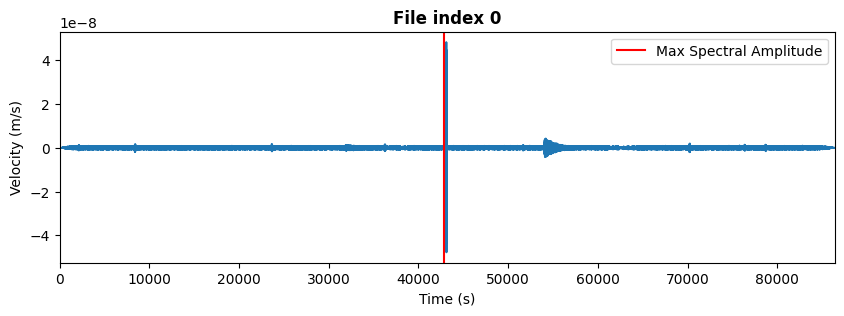

In [92]:
final_test = get_file_data(file_index)
times = final_test.time
data = final_test.data

# plot
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(times, data)

# Make the plot pretty
ax.set_xlim([min(times), max(times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'File index 0', fontweight='bold')

# Plot where the arrival time is
# arrival_line = ax.axvline(x=event_time, c='red', label='Rel. Arrival')
# ax.legend(handles=[arrival_line])

# Draw a line on the maximum spectral amplitude
max_spectral_amplitude_line = ax.axvline(x=times[max_spectral_amplitude_index], c='red', label='Max Spectral Amplitude')
ax.legend(handles=[max_spectral_amplitude_line])

plt.show()
